<h1><b>2A SETUP


In [1]:
def import_tensorflow():
    import os
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)
    import tensorflow as tf
    tf.get_logger().setLevel('INFO')
    tf.autograph.set_verbosity(0)
    import logging
    tf.get_logger().setLevel(logging.ERROR)
    return tf
tf = import_tensorflow()    

In [2]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 400)
import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf

import tensorflow_text as tf_text

In [44]:
class ShapeChecker():
  def __init__(self):
    self.shapes = {}
  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return
    parsed = einops.parse_shape(tensor, names)
    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      if (broadcast and new_dim == 1):
        continue
      if old_dim is None:
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

<h1><b> The data

In [6]:
from datasets import load_dataset

train_dataset  =   load_dataset("wmt16","de-en", split="train[:400000]")
val_dataset    =   load_dataset("wmt16","de-en", split="validation")
test_dataset   =   load_dataset("wmt16","de-en", split="test")

In [8]:
def extract_sentences(datadict):
    de_sentences=[]
    en_sentences=[]
    for de_en in datadict["translation"]:
        de_sentences.append(de_en['de'].lower())
        en_sentences.append(de_en['en'].lower())
    return np.array(de_sentences), np.array(en_sentences)

In [11]:
train_de , train_en  =  extract_sentences(train_dataset)
val_de   , val_en    =  extract_sentences(val_dataset)
test_de  , test_en   =  extract_sentences(test_dataset)

In [48]:
BUFFER_SIZE = len(train_de)
BATCH_SIZE = 128
is_train = np.random.uniform(size=(len(train_de),)) < 0.8
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_de[is_train],train_en[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_de[~is_train],train_en[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

normalisation and standardisation:

In [49]:
def tf_lower_and_split_punct(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

Text Vectorization

In [50]:
max_vocab_size = 75000
de_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)
de_text_processor.adapt(train_raw.map(lambda context, target: context))

In [51]:
en_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)
en_text_processor.adapt(train_raw.map(lambda context, target: target))
#target_text_processor.get_vocabulary()[:10]

### Process the dataset



In [52]:
def process_text(context, target):
  context = de_text_processor(context).to_tensor()
  target = en_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

<h3> <b>Encoder Decoder

In [53]:
UNITS = 512

In [54]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [55]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[  5  47   7 486 302 170 261   2  18 104]

[  4  67   7   2 515  16  15  13   3   7]
[ 67   7   2 515  16  15  13   3   7 174]


In [56]:
encoder = Encoder(de_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

<h3><b> Attention Layer

In [57]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [58]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(en_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)


In [59]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 1.        , 1.        , 1.0000001 ,
       0.9999999 , 1.        , 1.        , 1.        , 1.        ,
       1.0000001 , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 0.9999998 , 1.        , 1.        , 0.99999994,
       1.        , 0.99999994, 1.        , 0.9999998 , 1.        ,
       0.9999998 , 1.        , 1.        , 0.99999994, 1.0000001 ,
       0.9999999 , 1.        , 0.99999994, 1.        , 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994], dtype=float32)

In [60]:
attention_weights = attention_layer.last_attention_weights
#mask=(ex_context_tok != 0).numpy()

# plt.subplot(1, 2, 1)
# plt.pcolormesh(mask*attention_weights[:, 0, :])
# plt.title('Attention weights')

# plt.subplot(1, 2, 2)
# plt.pcolormesh(mask)
# plt.title('Mask');


<h3><b> Decoder

In [61]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Training

In [62]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [63]:
decoder = Decoder(en_text_processor, UNITS)

In [64]:
logits = decoder(ex_context, ex_tar_in)

In [65]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [66]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [67]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

In [68]:
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
#result[:3].numpy()

In [69]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    try:
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [70]:
model = Translator(UNITS, de_text_processor, en_text_processor)
logits = model((ex_context_tok, ex_tar_in))

<b><h1> Training

In [71]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [72]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

Configure the model for training:

In [73]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [74]:
# vocab_size = 1.0 * en_text_processor.vocabulary_size()

# {"expected_loss": tf.math.log(vocab_size).numpy(),
#  "expected_acc": 1/vocab_size}

That should roughly match the values returned by running a few steps of evaluation:

In [75]:
#model.evaluate(val_ds, steps=50, return_dict=True)

In [76]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 256,
    validation_data=val_ds,
    validation_steps = 32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/100
256/256 [==============================] - 55s 185ms/step - loss: 5.3338 - masked_acc: 0.2011 - masked_loss: 5.3338 - val_loss: 4.6722 - val_masked_acc: 0.2522 - val_masked_loss: 4.6722
Epoch 2/100
256/256 [==============================] - 44s 172ms/step - loss: 4.4971 - masked_acc: 0.2664 - masked_loss: 4.4971 - val_loss: 4.3853 - val_masked_acc: 0.2759 - val_masked_loss: 4.3853
Epoch 3/100
256/256 [==============================] - 44s 173ms/step - loss: 4.2972 - masked_acc: 0.2826 - masked_loss: 4.2972 - val_loss: 4.2259 - val_masked_acc: 0.2882 - val_masked_loss: 4.2259
Epoch 4/100
256/256 [==============================] - 44s 173ms/step - loss: 4.1780 - masked_acc: 0.2922 - masked_loss: 4.1780 - val_loss: 4.1265 - val_masked_acc: 0.2953 - val_masked_loss: 4.1265
Epoch 5/100
256/256 [==============================] - 44s 172ms/step - loss: 4.0936 - masked_acc: 0.2996 - masked_loss: 4.0936 - val_loss: 4.0532 - val_masked_acc: 0.3051 - val_masked_loss: 4.0532
Epoch 6/10

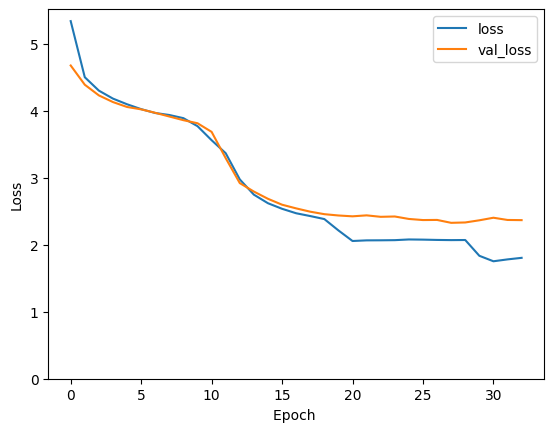

In [77]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch ')
plt.ylabel('Loss')
plt.legend()

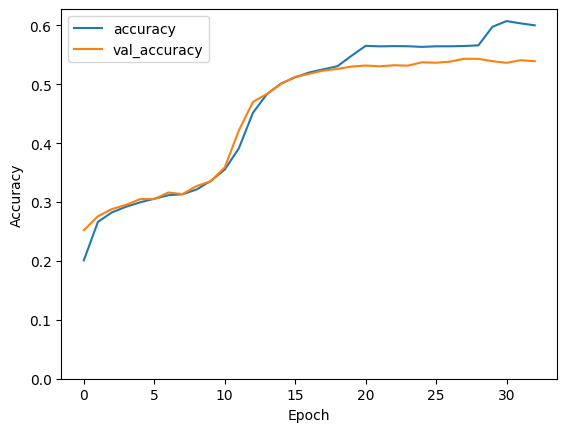

In [78]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [79]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [96]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [97]:
export = Export(model)

In [106]:
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

In [4]:
model = tf.saved_model.load('translator')

In [3]:
def translation_results(test_dataset):
  preds=[]
  for t in tqdm(test_dataset):
    preds.append(model.translate([t])[0].numpy().decode())
  return preds

In [9]:
import pickle
test_de_translations=translation_results(test_de)
x=pd.DataFrame({"actual":test_en, "predicted": test_de_translations})
x

100%|██████████| 2999/2999 [11:16<00:00,  4.43it/s]


,actual,predicted
0,obama receives netanyahu,noiseinduced deafness
1,the relationship between obama and netanyahu is not exactly friendly.,the relationship between the danube river and the netanyahu is not exactly friendly .
2,the two wanted to talk about the implementation of the international agreement and about teheran's destabilising activities in the middle east.,the two were intended to speak about the implementation of the international agreement and on the ad hoc hoc action in the middle east .
3,the meeting was also planned to cover the conflict with the palestinians and the disputed two state solution.,"however , when it comes to the dispute with the palestinians and the us we are talking about the twostate solution ."
4,relations between obama and netanyahu have been strained for years.,the relationship between the danube river and the netanyahu has been of great interest for years .
...,...,...
2994,mercury is released into the environment primarily through the burning of coal.,"mercury , mainly environmental audits , are the environment ."
2995,"german coal plants, according to written information from the german ministry of the environment to green bundestag member annalena baerbock, discharge more than six tonnes of mercury per year, two thirds of the total amount emitted in germany.",the german coal plants are being quoted according to a written document issued by the caa .
2996,"the concentration of mercury in fish, for example in the elbe, rhine and danube, is ""extensively exceeded on a long-term basis,"" the ""spiegel"" newspaper quoted from the paper in march.","the concentration of mercury in fish in fish is the elbe , the replacement of the biomass and the danube river , has been quoted in the wake of the paper ."
2997,"in the past year, europe-wide alerts on mercury in fish rated among the most frequently reported health risks in the eu warning system rasff.","last year , the total number of redundancies were already covered by the total of the health risks of the disease in jeopardy ."


In [10]:
val_de_translations=translation_results(val_de)
x=pd.DataFrame({"actual":val_en, "predicted": val_de_translations})
x

100%|██████████| 2169/2169 [07:57<00:00,  4.54it/s]


,actual,predicted
0,india and japan prime ministers meet in tokyo,the prime minister of india met in tokyo .
1,"india's new prime minister, narendra modi, is meeting his japanese counterpart, shinzo abe, in tokyo to discuss economic and security ties, on his first major foreign visit since winning may's election.","india has been razed to the ground , in its first important readings , since its election won in may , in may , in order to discuss economic and security relations with the japanese , in order to discuss economic and security relations ."
2,mr modi is on a five-day trip to japan to strengthen economic ties with the third largest economy in the world.,mr habib souaidia is right to strengthen the relationship with the third country in order to consolidate the economy s third largest country .
3,high on the agenda are plans for greater nuclear co-operation.,plans for a greater nuclear power are the top priority on the agenda .
4,india is also reportedly hoping for a deal on defence collaboration between the two nations.,reports that india are also united on with a treaty cooperation agreement between the two nations .
...,...,...
2164,the walkers started at 9.30 am.,the main salary of the midnight oil at . . . .
2165,"then it was the turn of the cyclists and runners, who began at 10 am.",the first cyclists and accidents have been taken at oclock .
2166,five minutes later the first mountain-bikers set off.,"five minutes later , the first week of distributing the first freight transport ."
2167,"bent hansen, chairman of the association 'cycling on the grosser feldberg' gave the starting orders and wished those taking part an enjoyable trip.","the jubilant militia camps , chairman of the association committee , were the main manufacturing lines , the main cerealgrowing areas , the main cerealgrowing areas , the main cerealgrowing areas ."


In [11]:
with open("translations_results.pkl","wb") as f:
    pickle.dump([val_de_translations,test_de_translations],f)

In [2]:
import pickle
with open("translations_results.pkl","rb") as f:
    val_de_translations,test_de_translations=pickle.load(f)

<h2><b>BLEU | METEOR | BERT Score

In [3]:
import evaluate
bleu=evaluate.load("bleu")
meteor=evaluate.load("meteor")
bertScore=evaluate.load("bertscore")

[nltk_data] Downloading package wordnet to /home/iiitd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/iiitd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/iiitd/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
def evaluation(predictions,actual):
    for i in range(1,5):
        results = bleu.compute(predictions=predictions, references=actual,max_order=i)
        print(f"BLEU-{i} results: ",results)

    results=meteor.compute(predictions=predictions, references=actual)
    print("\nMeteor Results : ",results)
    results=bertScore.compute(predictions=predictions, references=actual, lang='en')
    print("\nBertScore: ",results)

In [12]:
print("\nValidation dataset Evaluation: ")
evaluation(val_de_translations,val_en)

print("\nTest dataset Evaluation: ")
evaluation(test_de_translations,test_en)

Validation dataset Evaluation: 
BLEU-1 results: 
 {'bleu': 0.37749906867006083, 'precisions': [0.37749906867006083], 'brevity_penalty': 1.0, 'length_ratio': 1.0403720689877916, 'translation_length': 48318, 'reference_length': 46443}
BLEU-2 results: 
 {'bleu': 0.21457692073978532, 'precisions': [0.37749906867006083, 0.12196918809993283], 'brevity_penalty': 1.0, 'length_ratio': 1.0403720689877916, 'translation_length': 48318, 'reference_length': 46443}
BLEU-3 results: 
 {'bleu': 0.1313923720037701, 'precisions': [0.37749906867006083, 0.12196918809993283, 0.04926567544218615], 'brevity_penalty': 1.0, 'length_ratio': 1.0403720689877916, 'translation_length': 48318, 'reference_length': 46443}
BLEU-4 results: 
 {'bleu': 0.08351144009194787, 'precisions': [0.37749906867006083, 0.12196918809993283, 0.04926567544218615, 0.021442401931489493], 'brevity_penalty': 1.0, 'length_ratio': 1.0403720689877916, 'translation_length': 48318, 'reference_length': 46443}

Meteor Results : 
 {'meteor': 0.31274

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BertScore:  {'precision': [0.9122360944747925, 0.8384669423103333, 0.8622722625732422, 0.8967468738555908, 0.882927656173706, 0.8288441896438599, 0.8486132025718689, 0.8421233296394348, 0.8599801063537598, 0.8361684679985046, 0.8357506990432739, 0.8334370851516724, 0.8499454259872437, 0.8346530795097351, 0.9168421030044556, 0.8989938497543335, 0.8803643584251404, 0.8410918116569519, 0.8080213665962219, 0.8730837106704712, 0.9281264543533325, 0.8550471067428589, 0.848495602607727, 0.8589200973510742, 0.9029537439346313, 0.8420937061309814, 0.8960981369018555, 0.8534574508666992, 0.8796025514602661, 0.8660894632339478, 0.8314673900604248, 0.8806643486022949, 0.8692543506622314, 0.8573950529098511, 0.8886598348617554, 0.8714078068733215, 0.8550658226013184, 0.877668023109436, 0.8548003435134888, 0.818505048751831, 0.8922784328460693, 0.8714801669120789, 0.8926606178283691, 0.8911246657371521, 0.8487939834594727, 0.8769047856330872, 0.8592164516448975, 0.8379970788955688, 0.83363473415374

In [14]:
sentence=input("enter your sentence :")
results=translation_results([sentence])
print(results)

100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

['the political meeting was right                                             ']


In [11]:
import pandas as pd
data=pd.read_csv("input.csv",encoding='unicode_escape')

german_sentences=data['de'].tolist()

results=translation_results(german_sentences)
data["en"]=results
display(data)

100%|██████████| 3/3 [00:00<00:00,  4.52it/s]


,de,en
0,wie hei§t du,in other words you
1,Mein Name ist Obama,my name is ramiro zapata
2,Das politische Treffen wurde richtig durchgefhrt,the political meeting was right
